In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.maths import compute_centre, compute_normal_from_raw
from histalign.backend.models import Orientation, Resolution, VolumeSettings
from histalign.backend.workspace import VolumeSlicer

vedo.settings.default_backend = "vtk"

In [2]:
def imshow(image):
    plt.imshow(image)
    plt.axis(False)
    plt.show()


def show(data):
    vedo.show(data, axes=2, interactive=False).interactive().close()


def generate_points(plane, shape):
    origin = plane.points[1]

    normal1 = (plane.points[0] - plane.points[1]) / shape[0]
    normal2 = (plane.points[3] - plane.points[1]) / shape[1]

    xi, yi = np.meshgrid(
        np.linspace(0, shape[0], shape[0]), np.linspace(0, shape[1], shape[1])
    )

    points = np.vstack([xi.ravel(), yi.ravel()])
    points = np.dot(np.vstack((normal1, normal2)).T, points).T

    points = origin + points

    return vedo.Points(points)


def magnitude(v):
    return np.sqrt(np.sum(np.array(v) ** 2))

In [3]:
atlas = get_atlas_path(Resolution.MICRONS_100)
atlas: vedo.Volume = load_volume(atlas)

In [4]:
settings = VolumeSettings(
    orientation=Orientation.CORONAL,
    resolution=Resolution.MICRONS_100,
    shape=atlas.shape,
    pitch=0,
    yaw=0,
    offset=20,
)

In [5]:
atlas_slicer = VolumeSlicer(volume=atlas)

In [6]:
atlas_display_plane = atlas_slicer.slice(settings, return_display_plane=True)
atlas_plane_mesh = atlas_slicer.slice(settings, return_plane_mesh=True)

In [7]:
shape = tuple(map(int, (1.5 * max(atlas.shape),) * 2))
centre = (np.array(atlas.shape) - 1) // 2

In [8]:
atlas_image: np.ndarray = atlas_slicer.slice(settings)

In [9]:
display_plane = vedo.Plane(
    centre + [settings.offset, 0, 0], (1, 0, 0), s=shape, c="blue"
)
display_points = generate_points(display_plane, shape=shape)
display_points.pointdata["ImageScalars"] = atlas_image.astype(np.uint8).flatten()

output = vedo.Volume(np.zeros_like(atlas.tonumpy()))
output = output.interpolate_data_from(display_points, radius=1)

output_slicer = VolumeSlicer(volume=output)
output_image = output_slicer.slice(settings)

In [10]:
for _ in range(20):
    display_plane = vedo.Plane(
        centre + [settings.offset, 0, 0], (1, 0, 0), s=shape, c="blue"
    )
    display_points = generate_points(display_plane, shape=shape)
    display_points.pointdata["ImageScalars"] = output_image.astype(np.uint8).flatten()

    output = vedo.Volume(np.zeros_like(atlas.tonumpy()))
    output = output.interpolate_data_from(display_points, radius=1)

    output_slicer = VolumeSlicer(volume=output)
    output_image = output_slicer.slice(settings)

In [11]:
atlas_display_plane.center

array([85., 39., 56.], dtype=float32)

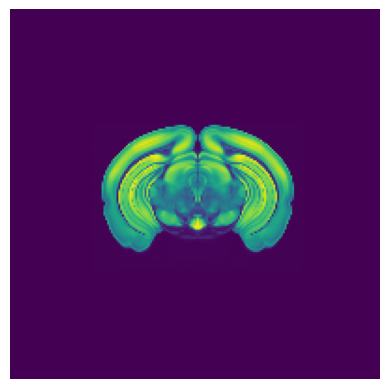

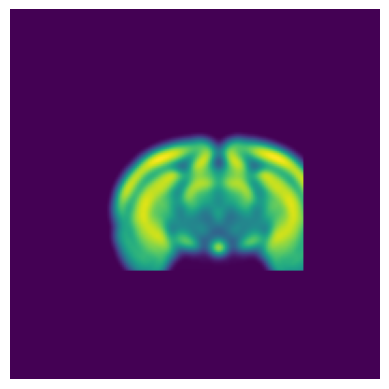

In [12]:
# roi = (slice(60, 138), slice(0, 100))
# roi = (slice(62, 70), slice(80, 100))
roi = (slice(None), slice(None))

imshow(atlas_image[roi])

imshow(output_image[roi])